# Определение возраста покупателей

# Цель исследования
1. Обучить модель, которая по фотографии определит приблизительный возраст человека. 

# Ход исследования
Нам предоставлен набор фотографий людей с указанием возраста. В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age. О качестве данных нам ничего не известно, поэтому перед тем, как приступать к целям исследования, понадобится обзор данных. Мы проверим данные на ошибки и подготовим данные к обучению. Далее приступим к целям исследования.<br>


Таким образом, исследование пройдёт в семь этапов:<br>

* Обзор данных 
* Анализ набора фотографий
* Подготовка данных к обучению
* Обучение модели нейронной сети
* Выявление лучшей модели 
* Написание промежуточных выводов 
* Написание общего вывода

## Исследовательский анализ данных

In [1]:
#Импортируем необходимые библиотеки 
from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import  pandas as pd
import numpy as np
from PIL import Image

In [2]:
#Выполняем загрузку данных
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory='/datasets/faces/final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        seed=12345) 

Found 7591 validated image filenames.


Найдено 7 591 изображений

In [3]:
#Cмотрим размер выборки
labels.shape

(7591, 2)

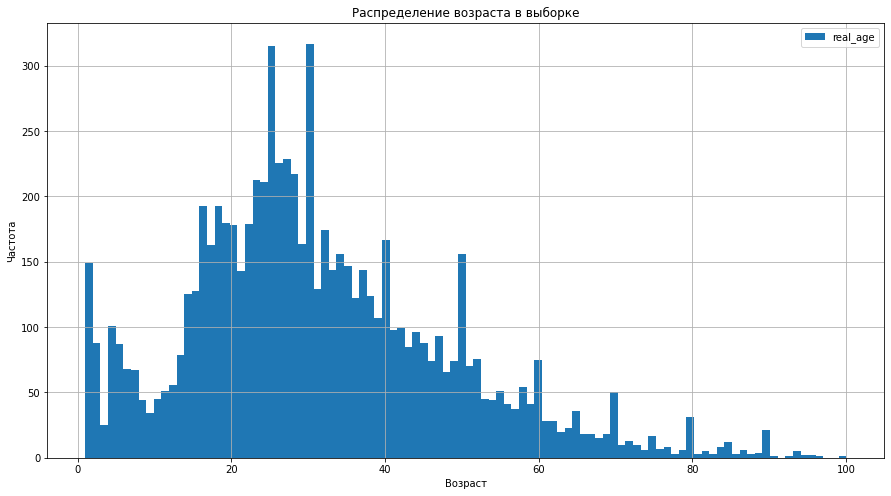

In [4]:
#Построим график распределения возраста в выборке
labels.plot(kind='hist', bins=100, figsize=(15,8), grid=True).set_title('Распределение возраста в выборке');

#Добавляем заголовки для осей
plt.ylabel('Частота');
plt.xlabel('Возраст');

В наборе фотографий людей с указанием возраста, большинство фотографий людей в возрасте от 25 до 35 лет, так же большой объем фотографий приходится на возвраст покупателей от 5 до 20 лет и от 40 до 60 лет. 

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


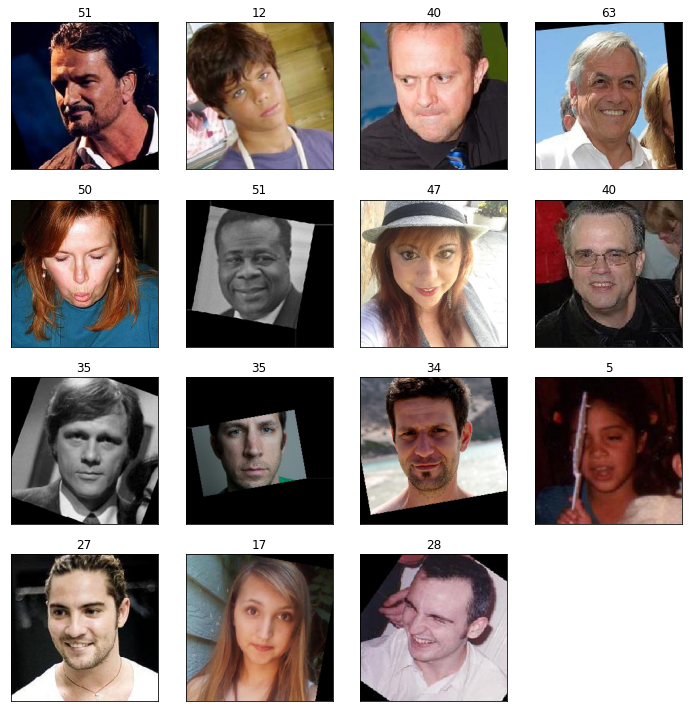

In [7]:
#Напечатаем на экране 10–15 фотографий и посмотрим, как устроен датасет
features, target = next(train_gen_flow)

# выводим 15 изображений
fig = plt.figure(figsize=(10, 10))
for i in range(15):
    fig.add_subplot(4, 4, i+1)
    plt.imshow(features[i])
    plt.title(target[i])
    # для компактности удаляем оси и прижимаем изображения друг к другу
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()    

### Вывод:
Мы провели исследовательский анализ данных:
* Посмотрели на размер выборки - найдено 7 591 изображений
* Построили график распределения возраста в выборке
* Напечатали на экране 10–15 фотографий и посмотрели, как устроен датасет - большинство фотографий приходится на людей  в возрасте от 25 до 35 лет

Можно предположить, что из-за того, что большинству людей на наборе данных от 25 до 35 лет, модель хорошо обучиться определять именно данный возраст, более младшее и старшее поколение будет определяться не с такой точностью. Так же можно заметить, что на фотографиях присутствуют объекты, которые мгут помешать успешному обучению модели - жвачка, рука, загораживающая половину лица, микрофон, кепка, так же есть фотогоафия, где человек на портрете в профиле, из-за чего модели будет трудно определить его возраст и правильно обучиться. 

## Обучение модели

(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python


from tensorflow.keras.layers import Conv2D, Flatten, GlobalAveragePooling2D, Dense, AvgPool2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50
import matplotlib.pyplot as plt
import  pandas as pd
import numpy as np
from PIL import Image



def load_train(path):
    train_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    labels = pd.read_csv(path + 'labels.csv')
    train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)

    return train_gen_flow

def load_test(path):
    valid_datagen = ImageDataGenerator(validation_split=0.25, rescale=1/255)
    labels = pd.read_csv(path + 'labels.csv')
    val_gen_flow = valid_datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)

    return val_gen_flow


def create_model(input_shape):
    backbone = ResNet50(input_shape=input_shape,
                        weights='/datasets/keras_models/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5',
                        include_top=False)

    model = Sequential()
    optimizer = Adam(lr=0.0001)

    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(units=10, activation='relu'))

    model.compile(optimizer=optimizer, loss='mean_squared_error',
                  metrics=['mae'])
    return model

def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):
    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2, shuffle=True)
    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/10
2023-09-18 18:57:44.478376: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2023-09-18 18:57:44.926527: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 79s - loss: 362.5756 - mae: 14.0298 - val_loss: 1047.8807 - val_mae: 27.7322
Epoch 2/10
178/178 - 57s - loss: 71.9970 - mae: 6.3266 - val_loss: 796.1131 - val_mae: 23.0142
Epoch 3/10
178/178 - 56s - loss: 35.8989 - mae: 4.5779 - val_loss: 220.0197 - val_mae: 10.9461
Epoch 4/10
178/178 - 58s - loss: 21.8172 - mae: 3.6119 - val_loss: 107.1712 - val_mae: 7.9478
Epoch 5/10
178/178 - 54s - loss: 15.7668 - mae: 3.0744 - val_loss: 82.0652 - val_mae: 6.9120
Epoch 6/10
178/178 - 57s - loss: 13.4058 - mae: 2.8396 - val_loss: 77.1874 - val_mae: 6.6660
Epoch 7/10
178/178 - 58s - loss: 12.9080 - mae: 2.7905 - val_loss: 72.0694 - val_mae: 6.4469
Epoch 8/10
178/178 - 57s - loss: 11.8094 - mae: 2.6554 - val_loss: 83.5543 - val_mae: 7.1464
Epoch 9/10
178/178 - 57s - loss: 9.7991 - mae: 2.3660 - val_loss: 70.7665 - val_mae: 6.3734
Epoch 10/10
178/178 - 54s - loss: 8.2008 - mae: 2.1378 - val_loss: 77.0381 - val_mae: 6.6042
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 10s - loss: 77.0381 - mae: 6.6042
Test MAE: 6.6042

```

### Вывод
* Мы подготовили данные к обучению;
* Обучили нейронную сеть и рассчитали её качество

## Анализ обученной модели

* В данной исследовательской работе мы рассматривали модели на основе свёрточной сети ResNet50 предобученной на наборе изображений ImageNet. В качестве головы были использованы слой GlobalAveragePooling2D, а также полносвязный слой Dense с 10 выходами (нейронами) и функцией активации relu. Функция потерь была MSE, метрика качества - MAE. Размер изображений приводили к 224х224, размер батча - 32 изображения.
* Наилучшая модель свёрточной сети ResNet50 со значением MAE: 2.1378 получилась при 10 эпохах и learning_rate оптимизатора Adam при 0.0001. Мы добились значение MAE не больше 8. 
* Наша модель может с хорошей точностью предсказывать возраст покупателей в сетевом супермаркете «Хлеб-Соль».

## Выводы

1. Мы провели исследовательский анализ набора фотографий:
    * Найдено 7 591 изображений
    * Большинство фотографий приходится на людей в возрасте от 25 до 35 лет
2. Подготовили данные к обучению
3. Обучили нейронную сеть и рассчитали её качество:
    * Наилучшая модель свёрточной сети ResNet50 со значением MAE: 2.1378 при 10 эпохах и learning_rate оптимизатора Adam при 0.0001     
    * Добились значение MAE не больше 8

Рекомендации: <br>
С помощью нашей модели, которая обладает высокой точностью и, которая обучалась с помощью нейронной сети, сетевой супермаркет «Хлеб-Соль» сможет анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы, следовательно, это поможет снизить количество очередей на кассе и привлечь намного больше лояльных клиентов. Так же, с помощью нашей модели, супермаркет может контролировать добросовестность кассиров при продаже алкоголя, что значительно улучшит качество работы самих сотрудников сети и исключит проблемы с законом. 